In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

In [4]:
final_df = pd.read_csv("mergedData(negative&positive).csv")


final_df = final_df.sample(frac=1)

final_df['bigramPref'] = ["^{0}$".format(row['prefix']) for i, row in final_df.iterrows()] 

final = final_df.copy()

final['prefix'] = final['prefix'].astype('str')

final['bigramPref'] = final['bigramPref'].astype('str')



In [6]:
final.head()

,prefix,label,bigramPref,pref_len
7967132,labs.133-116,1,^labs.133-116$,12
19862940,mta34bdfaa75cd4,0,^mta34bdfaa75cd4$,15
1989420,guojiyuleshangwuhuisuo,1,^guojiyuleshangwuhuisuo$,22
7925342,153-149.microscope,1,^153-149.microscope$,18
5969272,doc-qta,1,^doc-qta$,7


In [5]:
pref_len = [len(row['prefix']) for i,row in final.iterrows()]

final['pref_len'] = pref_len

XAll = final[['bigramPref','pref_len','prefix']]
target = final[['label']]
qname_train, qname_test, label_train, label_test = train_test_split(XAll, target, test_size=0.2, random_state = 1234)

In [7]:
qname_train.head()

,bigramPref,pref_len,prefix
15169600,^u9fzeucr8rlfmkusglcybaaojeao81520714903$,39,u9fzeucr8rlfmkusglcybaaojeao81520714903
15267837,^tecnologiabolivia$,17,tecnologiabolivia
17222667,^1-b53f3f278b81d80a4384aac19c3d6c0e$,34,1-b53f3f278b81d80a4384aac19c3d6c0e
19932416,^r-t-aiv4w954k3report$,20,r-t-aiv4w954k3report
7259666,^142-205-sourcegraph$,19,142-205-sourcegraph


In [8]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X_train = vectorizer.fit_transform(qname_train['bigramPref'])

combined_train_X = hstack((X_train ,np.array(qname_train['pref_len'])[:,None])).tocsr()

X_test = vectorizer.transform(qname_test['bigramPref'])
combined_test_X = hstack((X_test,np.array(qname_test['pref_len'])[:,None])).tocsr()


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.73
0.8931908679796841


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.90
0.9686337766781241


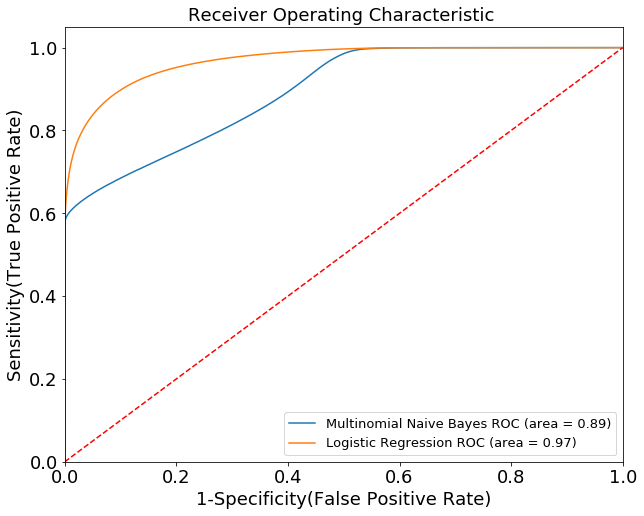

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

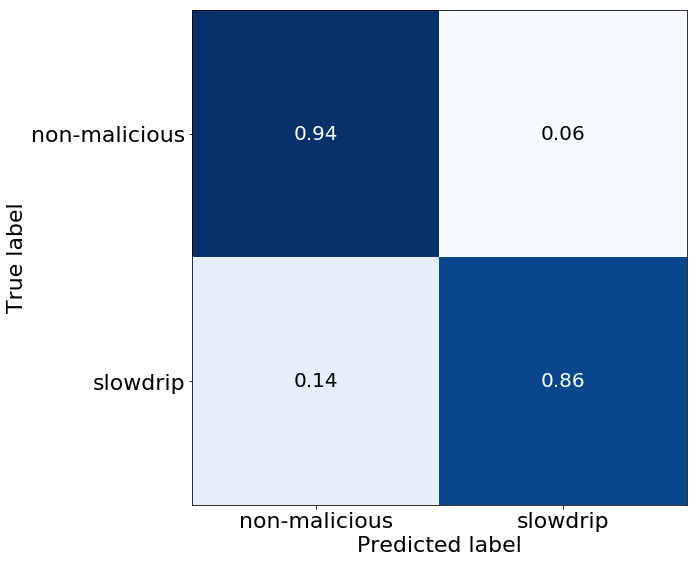

In [27]:
buildModel(combined_train_X, combined_test_X, label_train, label_test)

In [26]:
def buildModel(combined_train_X, combined_test_X, label_train, label_test):
    plt.figure(figsize=(10,8))
    models = [

    {
        'label': 'Multinomial Naive Bayes',
        'model': MultinomialNB(alpha= 0.001),
    },
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(solver= 'saga'),
    }
    ]

    # Below for loop iterates through your models list
    for m in models:
        model = m['model'] # select the model
        model.fit(combined_train_X, label_train) # train the model
        y_pred=model.predict(combined_test_X) # predict the test data
        print("%.2f" %accuracy_score(label_test ,y_pred))
    # Compute False postive rate, and True positive rate
        y_prob = model.predict_proba(combined_test_X)[:,1]
        fpr, tpr, thresholds = roc_curve(label_test, y_prob)

    # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(label_test, y_prob)
        print(auc)
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

#         CM = confusion_matrix(label_test, y_pred)
#         CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
#         print(CM)
#     # Now, plot the computed values
#         plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    # Custom settings for the plot 
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize = 18)
    plt.xlabel('1-Specificity(False Positive Rate)', fontsize = 18)
    plt.ylabel('Sensitivity(True Positive Rate)',fontsize = 18)
    plt.title('Receiver Operating Characteristic ',fontsize = 18)
    plt.legend(loc="lower right",fontsize = 13)
    plt.show()
    
    plt.savefig("/home/sonia90/capstone/prefixesData/ROC.png",dpi = 200)  # Display
    plt.rcParams.update({'font.size': 22})
    
    plot_confusion_matrix(label_test, y_pred, cmap=plt.cm.Blues)

#     plt.figure(figsize=(8,7))
#     sns.set(font_scale=1.4)
#     ax= plt.subplot()
#     sns.heatmap(cm, annot=True, ax = ax, annot_kws={"size": 16}); #annot=True to annotate cells

#     # labels, title and ticks
#     # sns.set_context(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20}) 
#     ax.set_xlabel('Predicted labels',fontsize = 17);ax.set_ylabel('True labels',fontsize=17); 
#     ax.set_title('Confusion Matrix',fontsize=20); 
#     ax.xaxis.set_ticklabels(['non-malicious', 'slowdrip'],fontsize = 15);
#     ax.yaxis.set_ticklabels(['non-malicious', 'slowdrip'],fontsize = 15);
    

In [24]:
def plot_confusion_matrix(y_true, y_pred, 
                          normalize=True,                          
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['non-malicious', 'slowdrip']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
#            /title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels())

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center",fontsize = 20,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

